In [1]:
!pip install imbalanced-learn
!pip install pmdarima
!pip install optuna
!pip install optuna-integration

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error,  r2_score, confusion_matrix, precision_score, recall_score, roc_auc_score 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from pmdarima.metrics import smape
from sklearn.metrics import make_scorer, roc_curve, auc, roc_auc_score
import optuna
from optuna.integration import OptunaSearchCV

## Задача 1: предсказание уровня удовлетворённости сотрудника

**Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

В данной работе нам требуется:

1. изучить датасет
2. сделать предобработку(избавиться от дубликатов, пустных значений)
3. провести исследовательский анализ данных.
4. обучить модели
5. написать выводы.

### Шаг 1. Загрузка данных

Проведем загрузку данных:

In [3]:
try:
    train_job_satisfaction_rate = pd.read_csv('datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('datasets/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('datasets/market_time.csv')
except:   
    train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [4]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
train_job_satisfaction_rate.shape[0]

4000

In [6]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [8]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [9]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [10]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Вывод: Данные соответсвуют описанию и готовы к предобработке.**

### Шаг 2. Предобработка данных

#### train_job_satisfaction_rate

In [11]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Проверка на дубликаты:

In [12]:
train_job_satisfaction_rate.duplicated().unique()

array([False])

In [13]:
train_job_satisfaction_rate['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

#### test_features

Проверка на дубликаты:

In [14]:
test_features.duplicated().unique()

array([False])

In [15]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [16]:
test_features[test_features['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


Один интересный пропуск найден, думаю его нужно удалить:

In [17]:
test_features.drop(test_features[test_features['workload'] == ' '].index, inplace=True)
test_features['workload'].unique()

array(['medium', 'low', 'high'], dtype=object)

In [18]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [19]:
test_features[test_features['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


Аналогичная ситуация:

In [20]:
test_features.drop(test_features[test_features['dept'] == ' '].index, inplace=True)
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [21]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     1998 non-null   int64 
 1   dept                   1996 non-null   object
 2   level                  1997 non-null   object
 3   workload               1998 non-null   object
 4   employment_years       1998 non-null   int64 
 5   last_year_promo        1998 non-null   object
 6   last_year_violations   1998 non-null   object
 7   supervisor_evaluation  1998 non-null   int64 
 8   salary                 1998 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.1+ KB


#### test_target_job_satisfaction_rate

In [22]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Проверим на дубликаты

In [23]:
test_target_job_satisfaction_rate.duplicated().unique()

array([False])

**Вывод.**

Данные обработанны. Дубликатов не замечено, а пропуски обработает пайплайн.

### Шаг 3. Исследовательский анализ данных

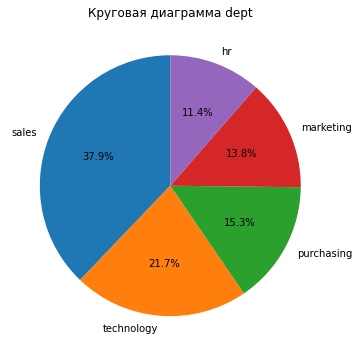

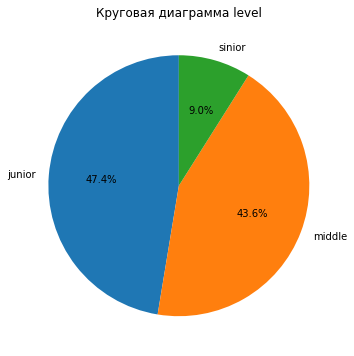

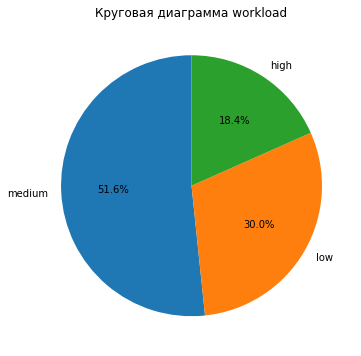

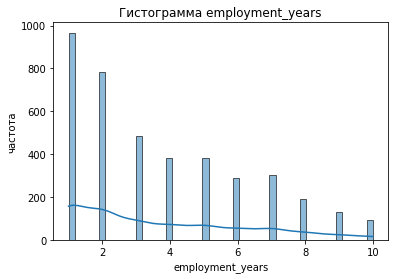

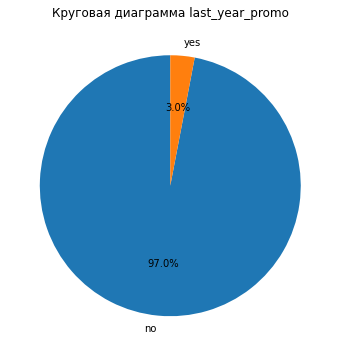

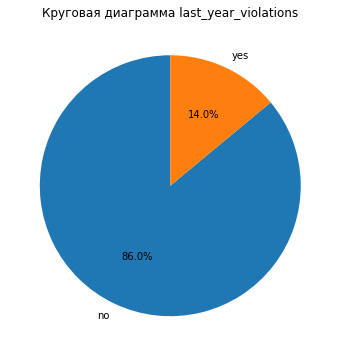

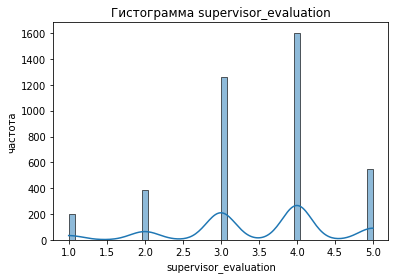

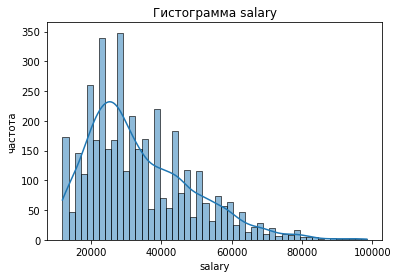

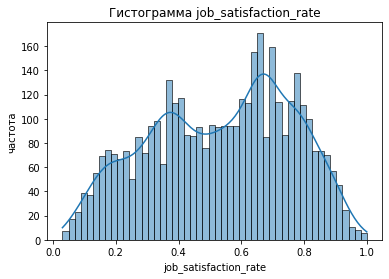

In [24]:
def plot_builder(df):
    for column in df:
        if column != 'id':
            if df[column].dtype == 'int64' or df[column].dtype == 'float64':
                plt.figure()
                sns.histplot(data=df[column], bins=50, kde=True)
                plt.title(f'Гистограмма {column}')
                plt.xlabel(column)
                plt.ylabel('частота')
                plt.show()
            else:
                plt.figure(figsize=(10, 6))
                value_counts = df[column].value_counts()
                plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%',startangle=90)
                plt.title(f'Круговая диаграмма {column}')
                plt.show()

plot_builder(train_job_satisfaction_rate)

In [25]:
best_rate_df = train_job_satisfaction_rate[train_job_satisfaction_rate['job_satisfaction_rate'] >= 0.6]
best_rate_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1,653870,hr,junior,high,2,no,no,5,38400,0.76
5,405448,hr,middle,low,7,no,no,4,30000,0.78
10,964158,purchasing,junior,low,2,no,no,4,13200,0.74
15,798010,technology,junior,medium,3,no,no,4,27600,0.69
17,955615,purchasing,junior,high,2,no,no,5,33600,0.64


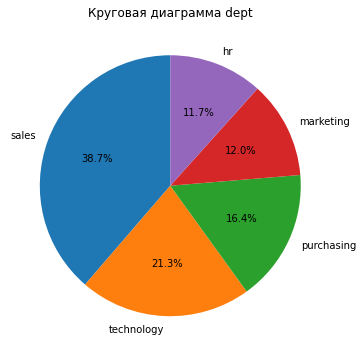

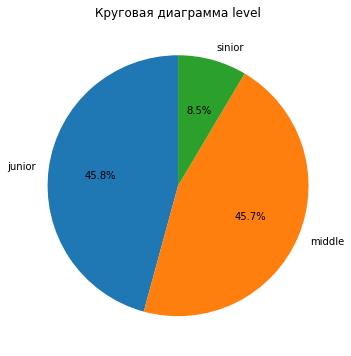

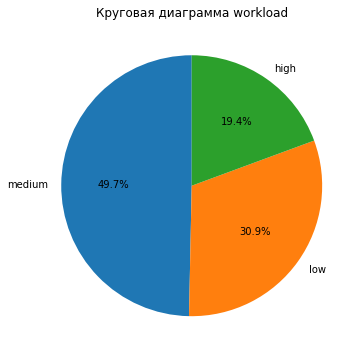

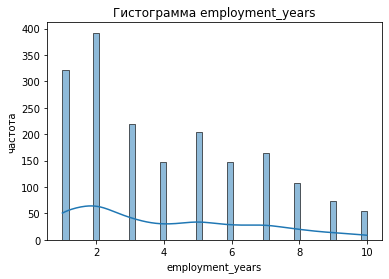

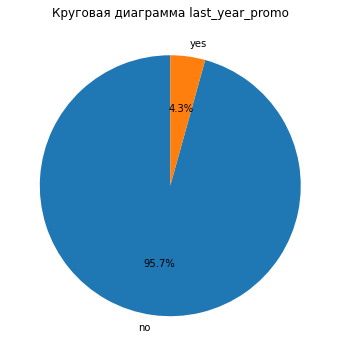

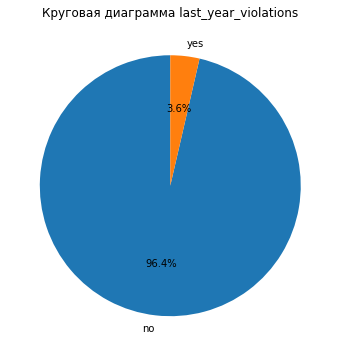

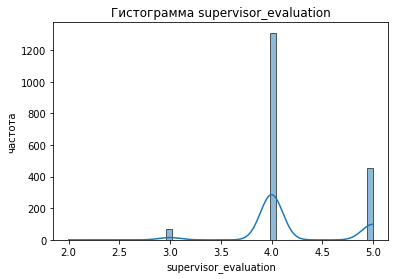

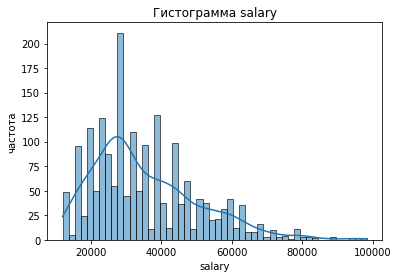

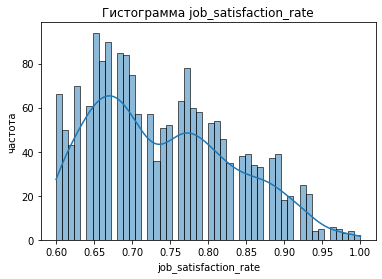

In [26]:
plot_builder(best_rate_df)

Судя по выбранному сегменту, особо выделяется признак загруженности. У кого большой рейтинг удовлетворенности, в основном (почти 50%) имеют среднюю загруженность.

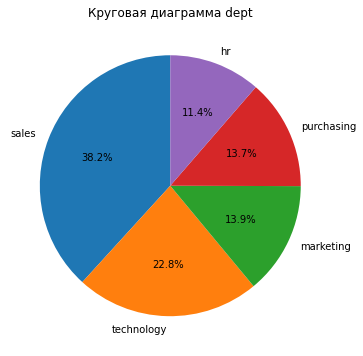

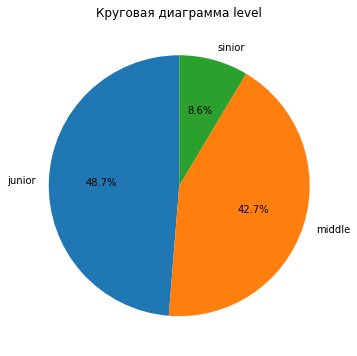

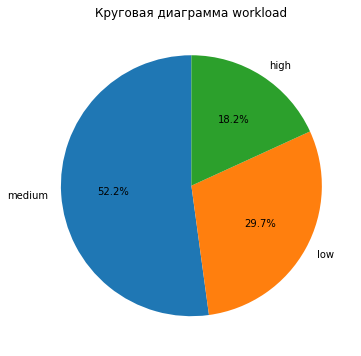

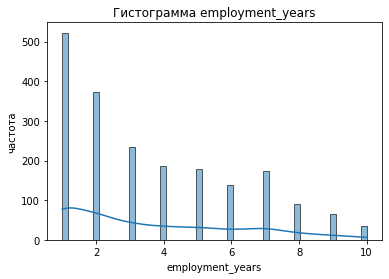

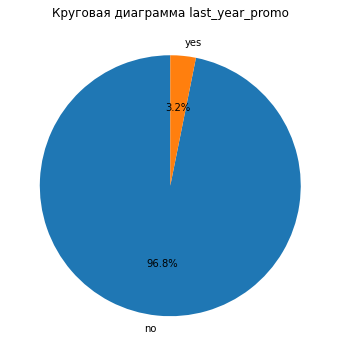

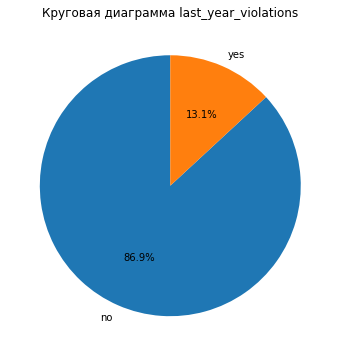

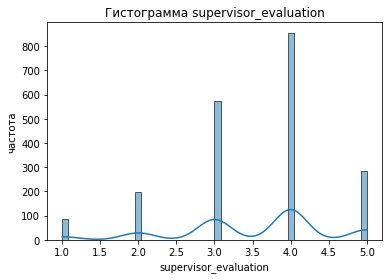

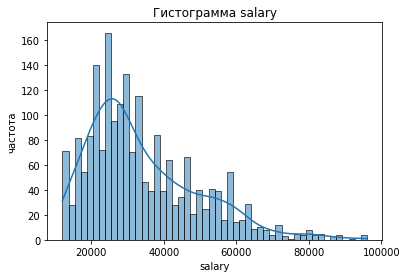

In [27]:
plot_builder(test_features)

Аномалий не замечено

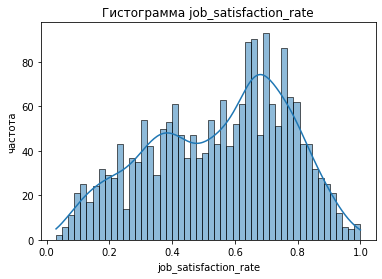

In [28]:
plot_builder(test_target_job_satisfaction_rate)

Корреляционный анализ:

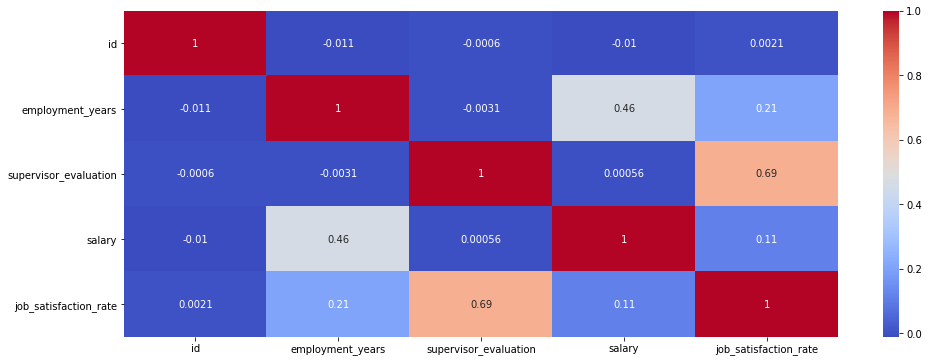

In [29]:
plt.figure(figsize=(16, 6))
sns.heatmap(train_job_satisfaction_rate.corr(), annot=True, cmap='coolwarm');

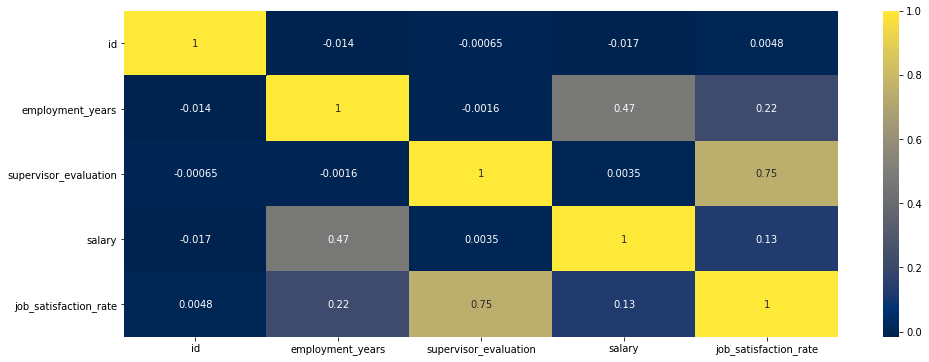

In [30]:
plt.figure(figsize=(16, 6))
sns.heatmap(train_job_satisfaction_rate.corr(method='spearman'), annot=True, cmap='cividis');

Соединим выборки в одну для удобства анализа:

In [31]:
test_target_job_satisfaction_rate = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left')

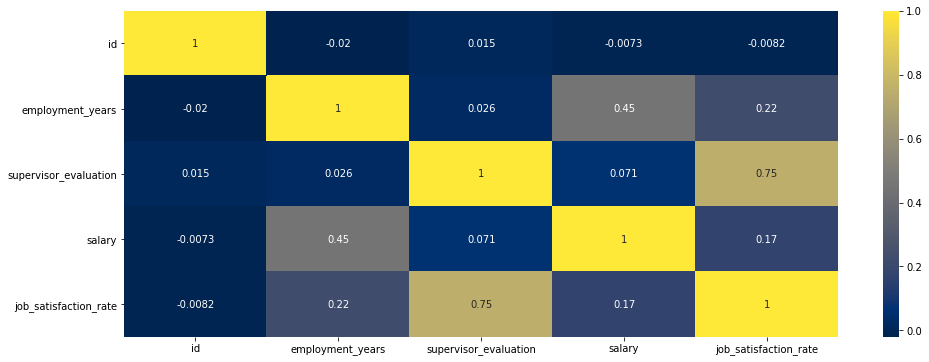

In [32]:
plt.figure(figsize=(16, 6))
sns.heatmap(test_target_job_satisfaction_rate.corr(method='spearman'), annot=True, cmap='cividis');

**Вывод**

Особых аномалий не замечено, данные в основном показывают нормальное распределение.

Судя по корреляционному анализу, с целевым признаком сильно коррелирует supervisor_evaluation. Может быть даже стоит в дальнейшем исключить его, чтобы не влиял на модель. Мультиколлениарность отсутствует.

### Шаг 4. Подготовка данных

In [33]:
print(train_job_satisfaction_rate.shape[0])
train_job_satisfaction_rate.head()

4000


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [34]:
ohe_columns = ['dept', 'level', 'last_year_promo', 'last_year_violations']
ord_columns = ['workload']
num_columns = ['id', 'employment_years', 'supervisor_evaluation', 'salary'] 

RANDOM_STATE = 42

X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
X_test = test_target_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_test = test_target_job_satisfaction_rate['job_satisfaction_rate']

**Вывод.**

Так как данные уже изначально разделены, использовать train_test_split не вижу смысла.

### Шаг 5. Обучение моделей

In [35]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error')
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[['low', 'medium', 'high']],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],  
    },
    
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': [0.001, 0.01, 0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],  
    },
]
smape_scorer = make_scorer(smape, greater_is_better=False)

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'level',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(

In [36]:
X_test['job_satisfaction_rate_pred'] = y_pred
X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.826988
1,686555,hr,junior,medium,1,no,no,4,30000,0.672710
2,467458,sales,middle,low,5,no,no,4,19200,0.667333
3,418655,sales,middle,low,6,no,no,4,19200,0.667333
4,789145,hr,middle,medium,5,no,no,5,40800,0.826780


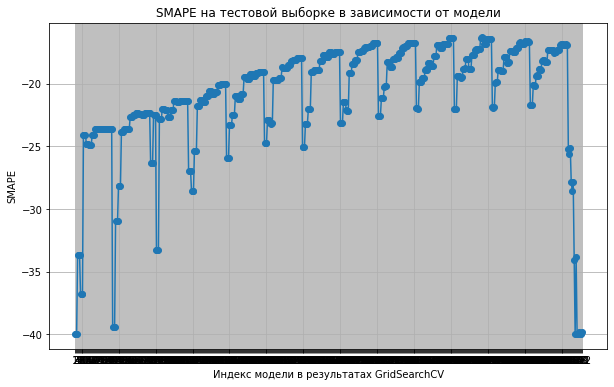

In [37]:
results = grid_search.cv_results_

params = results['params']
mean_smape = results['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_smape)), mean_smape, marker='o', linestyle='-')
plt.title('SMAPE на тестовой выборке в зависимости от модели')
plt.xlabel('Индекс модели в результатах GridSearchCV')
plt.ylabel('SMAPE')
plt.xticks(range(len(mean_smape)), range(1, len(mean_smape) + 1))
plt.grid(True)
plt.show()

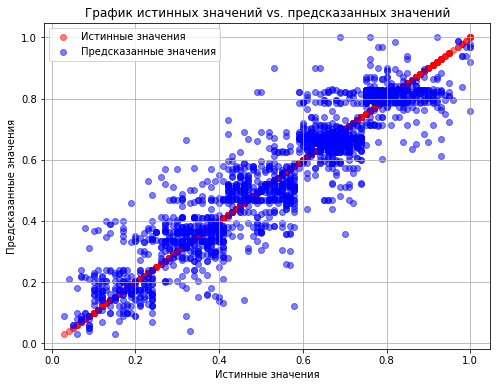

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test, color='red', alpha=0.5, label='Истинные значения')
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Предсказанные значения')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('График истинных значений vs. предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()

### Шаг 6. Оформление выводов

**Вывод**

Судя по пайплайну, лучше справилась дерево решений. Модель линейной регрессии может быть менее гибкой в сравнении с решающим деревом и может не улавливать нелинейные зависимости в данных так эффективно.

Тестирование лучшей модели:

In [39]:
grid_search.best_estimator_.fit(X_train, y_train)
y_pred_best = grid_search.best_estimator_.predict(X_test)
test_smape = smape(y_test, y_pred_best)
print(f'Значение SMAPE лучшей модели на тестовой выборке: {test_smape:.2f}')

Значение SMAPE лучшей модели на тестовой выборке: 15.24


## Задача 2: предсказание увольнения сотрудника из компании

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

### Шаг 1. Загрузка данных

In [40]:
try:
    train_quit = pd.read_csv('datasets/train_quit.csv')
    test_target_quit = pd.read_csv('datasets/test_target_quit.csv')
except:   
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [41]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [42]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [43]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [44]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


**Вывод.**

Данные соответствуют описанию:

### Шаг 2. Предобработка данных

#### train_quit

In [45]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Проверка на дубликаты

In [46]:
train_quit.duplicated().unique()

array([False])

In [47]:
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

#### test_target_quit

In [48]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Проверка на дубликаты:

In [49]:
test_target_quit.duplicated().unique()

array([False])

**Вывод**

Данные проверены, дубликатов и пропусков нет.

### Шаг 3. Исследовательский анализ данных

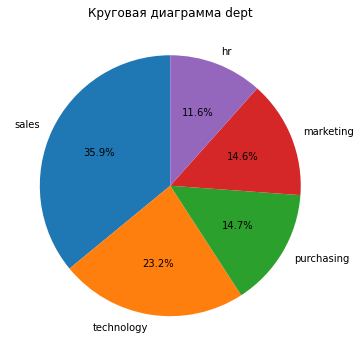

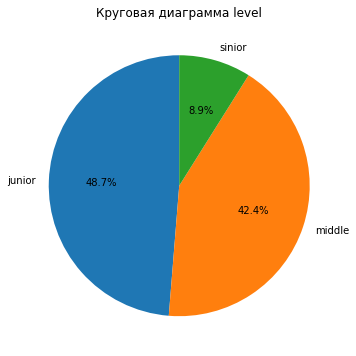

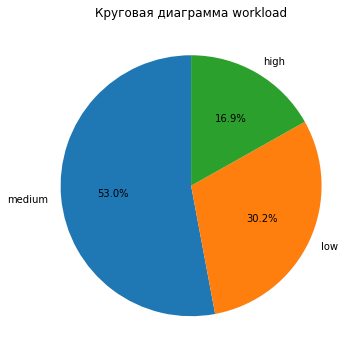

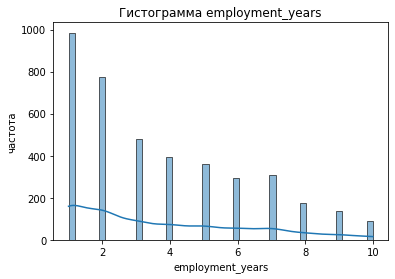

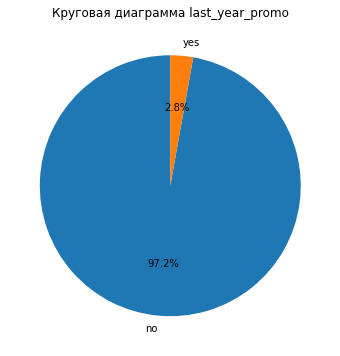

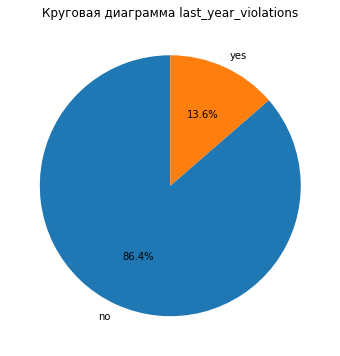

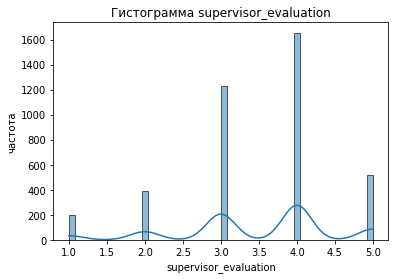

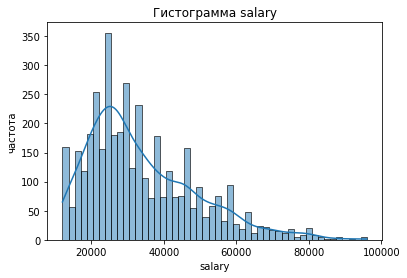

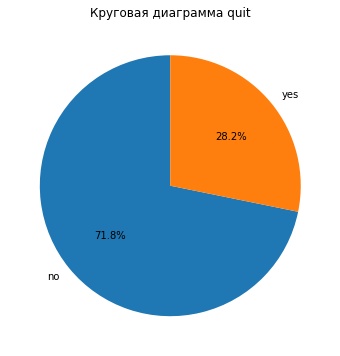

In [50]:
plot_builder(train_quit)

Аномалий не замечено

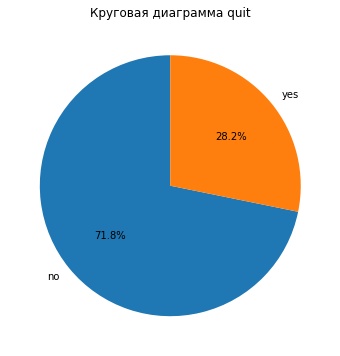

In [51]:
plot_builder(test_target_quit)

Корреляционный анализ:

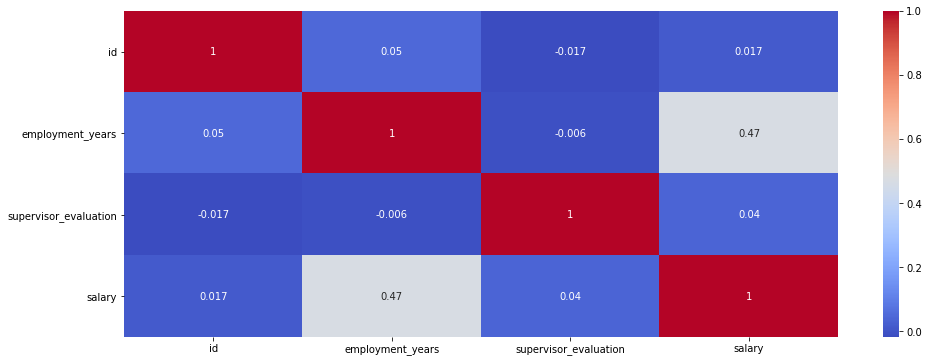

In [52]:
plt.figure(figsize=(16, 6))
sns.heatmap(train_quit.corr(), annot=True, cmap='coolwarm');

Сегмент уволившихся сотрудников:

In [53]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [54]:
filtered_fired = train_quit[train_quit['quit'].isin(['yes'])
]
print(filtered_fired.shape[0])
filtered_fired.head()

1128


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


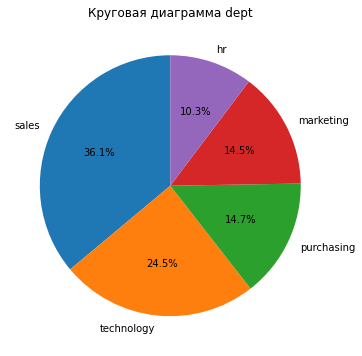

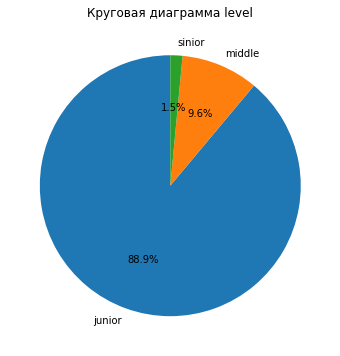

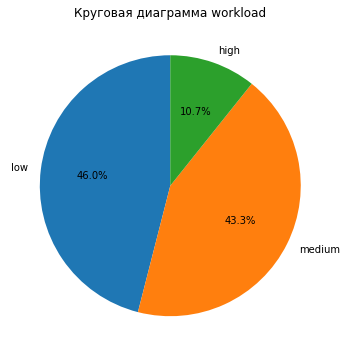

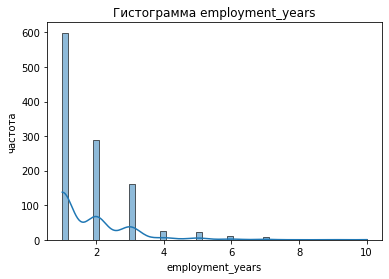

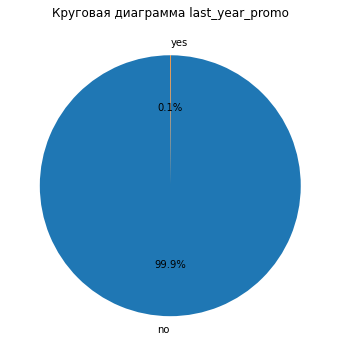

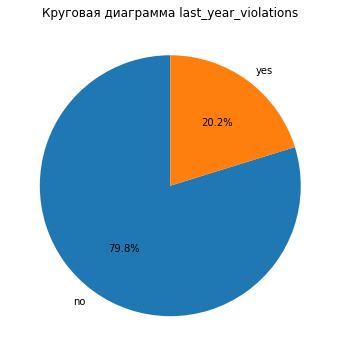

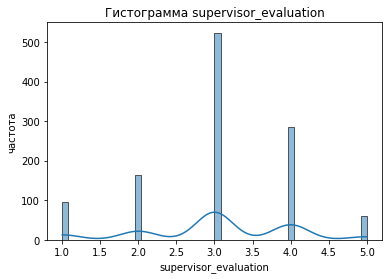

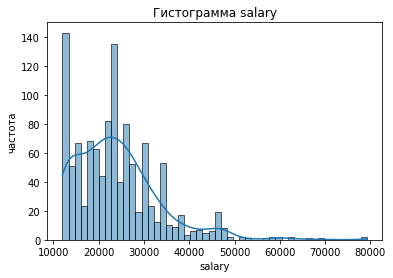

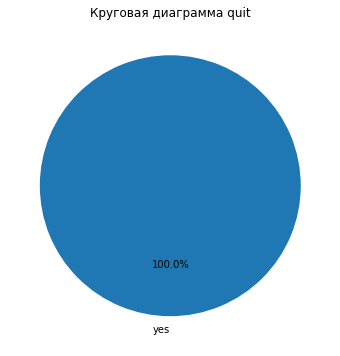

In [55]:
plot_builder(filtered_fired)

Судя по графикам, в основном увольнялись джуниоры, которые не получали повышения.

In [56]:
hr_ratio = filtered_fired[filtered_fired['dept'] == 'hr'].shape[0] / train_quit[train_quit['dept'] == 'hr'].shape[0]
sales_ratio = filtered_fired[filtered_fired['dept'] == 'sales'].shape[0] / train_quit[train_quit['dept'] == 'sales'].shape[0]
technology_ratio = filtered_fired[filtered_fired['dept'] == 'technology'].shape[0] / train_quit[train_quit['dept'] == 'technology'].shape[0]
purchasing_ratio = filtered_fired[filtered_fired['dept'] == 'purchasing'].shape[0] / train_quit[train_quit['dept'] == 'purchasing'].shape[0]
marketing_ratio = filtered_fired[filtered_fired['dept'] == 'marketing'].shape[0] / train_quit[train_quit['dept'] == 'marketing'].shape[0]

print('Доля уволивщихся hr:', hr_ratio, 'Количество уволивщихся', filtered_fired[filtered_fired['dept'] == 'hr'].shape[0])
print('Доля уволивщихся sales:', sales_ratio, 'Количество уволивщихся', filtered_fired[filtered_fired['dept'] == 'sales'].shape[0])
print('Доля уволивщихся technology:', technology_ratio, 'Количество уволивщихся', filtered_fired[filtered_fired['dept'] == 'technology'].shape[0])
print('Доля уволивщихся purchasing:', purchasing_ratio, 'Количество уволивщихся', filtered_fired[filtered_fired['dept'] == 'purchasing'].shape[0])
print('Доля уволивщихся marketing:', marketing_ratio, 'Количество уволивщихся', filtered_fired[filtered_fired['dept'] == 'marketing'].shape[0])


Доля уволивщихся hr: 0.25 Количество уволивщихся 116
Доля уволивщихся sales: 0.28303198887343534 Количество уволивщихся 407
Доля уволивщихся technology: 0.2974137931034483 Количество уволивщихся 276
Доля уволивщихся purchasing: 0.282312925170068 Количество уволивщихся 166
Доля уволивщихся marketing: 0.2800687285223368 Количество уволивщихся 163


Добавим удовлетворенность:

In [57]:
train_job_satisfaction_rate.shape[0]

4000

In [58]:
train_quit['job_satisfaction_rate'] = train_job_satisfaction_rate['job_satisfaction_rate']
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.58
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.76
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.11
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.37
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.20


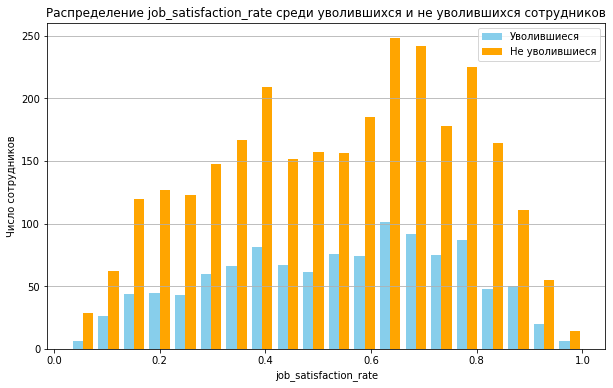

In [59]:
quit = train_quit[train_quit['quit'] == 'yes']
not_quit = train_quit[train_quit['quit'] == 'no']

plt.figure(figsize=(10, 6))
plt.hist([quit['job_satisfaction_rate'], not_quit['job_satisfaction_rate']], bins=20, color=['skyblue', 'orange'], label=['Уволившиеся', 'Не уволившиеся'])
plt.title('Распределение job_satisfaction_rate среди уволившихся и не уволившихся сотрудников')
plt.xlabel('job_satisfaction_rate')
plt.ylabel('Число сотрудников')
plt.legend()
plt.grid(axis='y')
plt.show()

Судя по графику нельзя сказать, что рейтинг сильно влиял на увольнение.

**Вывод**

Проведен исследовательский анализ данных. В основном везде нормальное распределение. По зарплате единственное есть вопросы, но я бы не сказал, что там аномалия.

Корреляционный анализ тоже не показал аномалий. Мультиколлениарности не наблюдается.

### Шаг 4. Добавление нового входного признака

Добавляем предсказанный рейтинг:

In [60]:
test_target_quit['job_satisfaction_rate'] = X_test['job_satisfaction_rate_pred']
test_target_quit.head()

,id,quit,job_satisfaction_rate
0,999029,yes,0.826988
1,372846,no,0.672710
2,726767,no,0.667333
3,490105,no,0.667333
4,416898,yes,0.826780


### Шаг 5. Подготовка данных

In [61]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [62]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.58
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.76
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.11
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.37
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.20


In [63]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
job_satisfaction_rate    0
dtype: int64

In [64]:
test_target_quit_with_pred = pd.merge(test_features, test_target_quit, on='id')
print(test_target_quit_with_pred.isna().sum())
test_target_quit_with_pred.head()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
job_satisfaction_rate    2
dtype: int64


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.300000
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.366000
2,467458,sales,middle,low,5,no,no,4,19200,no,0.430000
3,418655,sales,middle,low,6,no,no,4,19200,no,0.814419
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.664000


In [65]:
ohe_columns = ['dept', 'level', 'last_year_promo', 'last_year_violations']
ord_columns = ['workload']
num_columns = ['id', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 

RANDOM_STATE = 42

X_train = train_quit.drop(['quit'], axis=1)
y_train = train_quit['quit']
X_test = test_target_quit_with_pred.drop(['quit'], axis=1)
y_test = test_target_quit_with_pred['quit']

**Вывод.**

Так как данные уже изначально разделены, использовать train_test_split не вижу смысла.

### Шаг 6. Обучение моделей

In [66]:
ohe_pipe = Pipeline(
    [
         (
            'simpleImputer_before_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error')
        ),
        (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[['low', 'medium', 'high']],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

num_pipe = Pipeline(
    [
        (
            'simpleImputer_num', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'scaler', 
            StandardScaler()
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
    },
    
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['linear', 'rbf'],  
        'models__gamma': ['scale', 'auto'], 
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 15),  
    },
]


grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
y_pred2 = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first')),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['dept', 'level',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                       

Тест лучшей модели:

In [67]:
grid_search.best_estimator_.fit(X_train, y_train)
y_pred_proba_best = grid_search.best_estimator_.predict_proba(X_test)
y_pred_proba_positive = y_pred_proba_best[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_positive) 
print(f'Значение roc_auc лучшей модели на тестовой выборке: {roc_auc:.2f}')

Значение roc_auc лучшей модели на тестовой выборке: 0.92


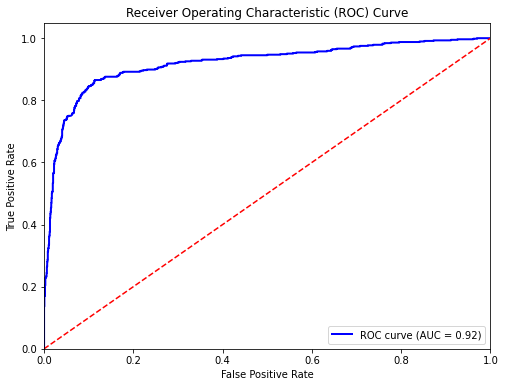

In [69]:
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_proba_positive_class = y_pred_proba[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba_positive_class)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

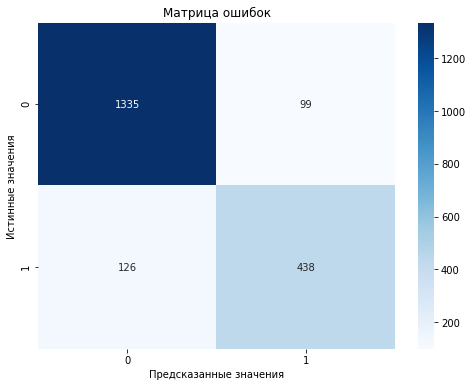

In [70]:
conf_matrix = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

### Шаг 7. Оформление выводов

**Вывод.**

Лучшая модель оказалась SVC, хотя дерево решений тоже справилась хорошо, разница всего в 1 процент. Эти модели хорошо работают при нелинейных связях.

## Общий вывод

1. **Проведена большая работа по предсказанию рейтинга удовлетворенности и вероятности увольнения. Рассматривая рейтинг, можно сказать что сильно на него влияет загруженность работника. Лучше всего справилась дерево решений. Метрика лучшей модели на тренировочной выборке: -16.30241171109499.**

**Чтобы поднять рейтинг, рекомендую граммотно распределять нагрузку на работников, чтобы они не перерабатывали.**

2. **По поводу вероятности увольнения, часто увольняются джуны, которые давно не получали повышения.  Лучше всего справилась модель SVC, но и дерево решений тоже себя хорошо показала. Метрика лучшей модели на тренировочной выборке: 0.9231086364823303**

**Чтобы добиться меньших увольнений, во первых нужно лучше отбирать кандидатов, чтобы были заинтересованны в росте, а так же поощерять джунов зарплатами и повыщениями.**
